In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from sklearn import manifold

from sklearn.datasets import make_circles, make_moons, make_blobs 


from sklearn.decomposition import PCA

In [3]:
# Data sets

In [4]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

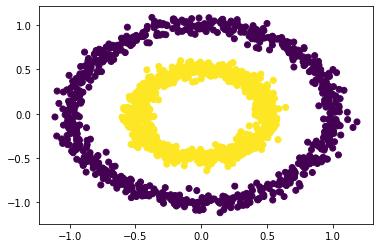

In [5]:
plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1],c=noisy_circles[1])

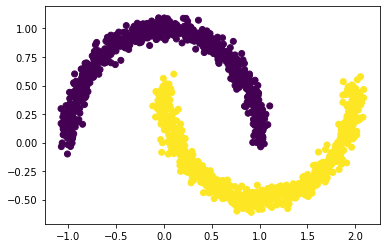

In [6]:
plt.scatter(noisy_moons[0][:,0],noisy_moons[0][:,1],c=noisy_moons[1])

In [7]:
#plt.scatter(blobs[0][:,0],blobs[0][:,1],c=blobs[1])

In [8]:
#plt.scatter(no_structure[0][:,0],no_structure[0][:,1],c=no_structure[1])

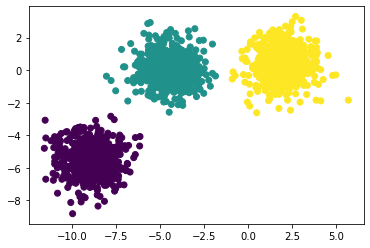

In [9]:
# blobs in 2D
plt.scatter(X[:,0],X[:,1],c=y)

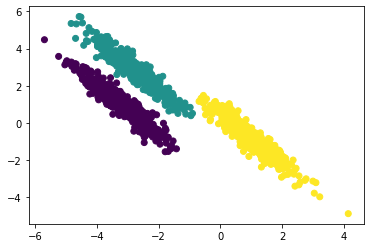

In [10]:
# anisotropic blobs
plt.scatter(X_aniso[:,0],X_aniso[:,1],c=y)

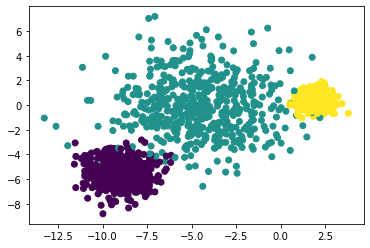

In [11]:
#blobs with different variance
plt.scatter(varied[0][:,0],varied[0][:,1],c=varied[1])

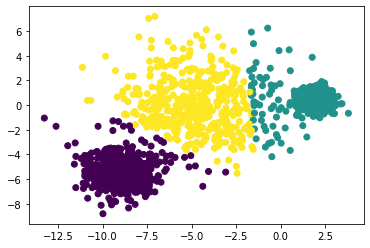

In [12]:
# K-Means clustering on blobs with different variance
kmeans=cluster.KMeans(n_clusters=3)
kmeans.fit(varied[0])
plt.scatter(varied[0][:,0],varied[0][:,1],c=kmeans.predict(varied[0]))

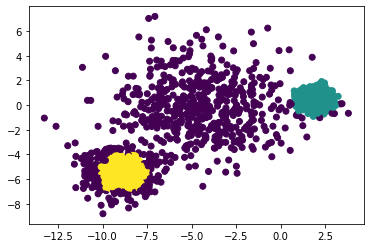

In [13]:
#DBSCAN on blobs with different variance

dbscan=cluster.DBSCAN(min_samples=40)
dbscan.fit(varied[0])
plt.scatter(varied[0][:,0],varied[0][:,1],c=dbscan.labels_)

Automatically created module for IPython interactive environment


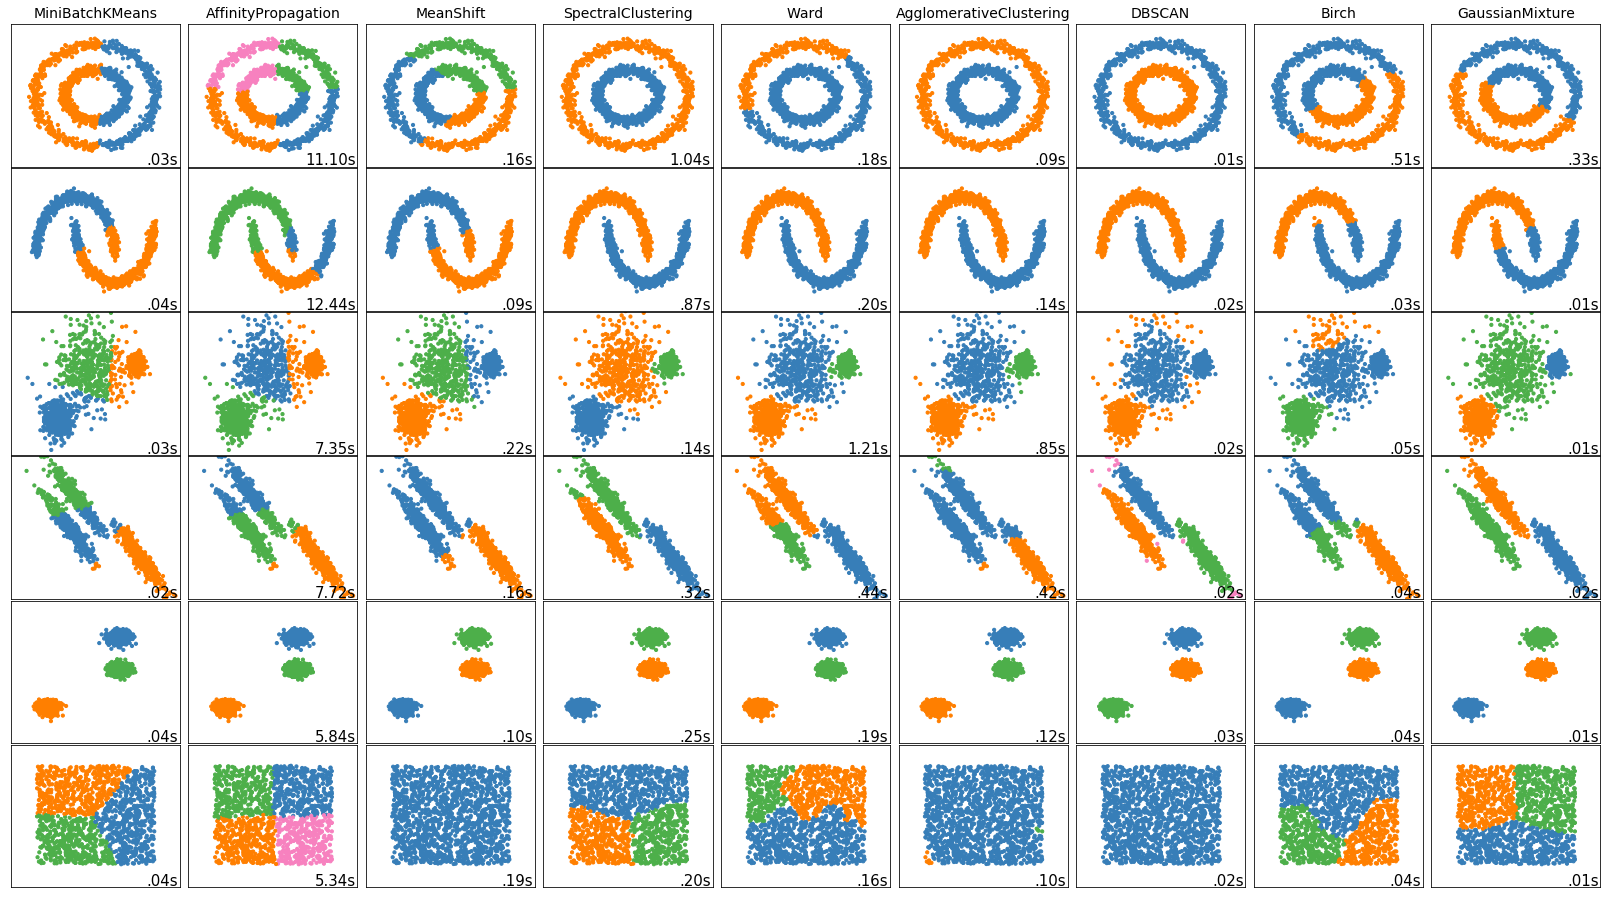

In [14]:
# from sklearn: https://scikit-learn.org/stable/modules/clustering.html

print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',**{'size':16})

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
%matplotlib inline
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 5, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [18]:
# let's go higher in dimension

n_true_center=15
X, y = datasets.make_blobs(10000, 40, n_true_center)


In [19]:
np.shape(X)

(10000, 40)

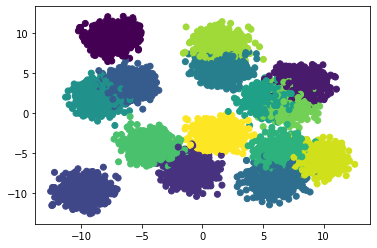

In [20]:
plt.scatter(X[:,0],X[:,1],c=y)

In [21]:
pca = PCA(n_components=40)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [22]:
Xt = pca.transform(X)

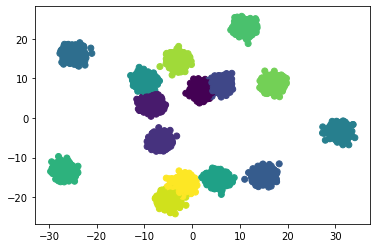

In [23]:
plt.scatter(Xt[:,0],Xt[:,1],c=y)

Text(0, 0.5, 'Standard Deviation')

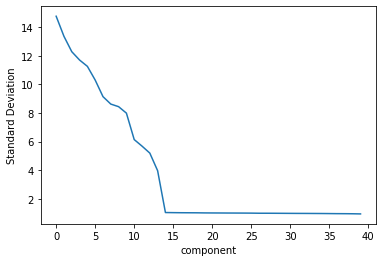

In [24]:
plt.plot(np.arange(len(Xt[0])),[np.std(Xt[:,i]) for i in range(len(Xt[0]))])
plt.xlabel('component')
plt.ylabel('Standard Deviation')

In [25]:
tsne = TSNE(n_components=2,perplexity=60.,n_iter=1000)

In [26]:
Xt= tsne.fit_transform(X)

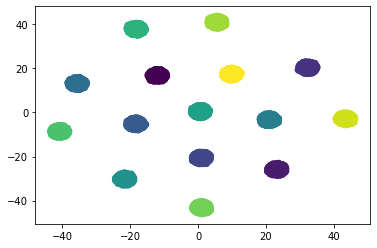

In [27]:
plt.scatter(Xt[:,0],Xt[:,1],c=y)

In [28]:
tsne = TSNE(n_components=2,perplexity=30.,n_iter=1000)

In [29]:
Xt= tsne.fit_transform(X)

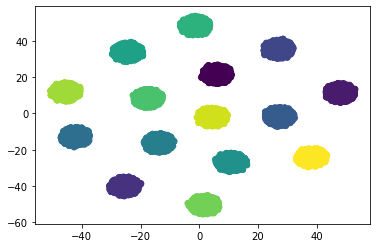

In [30]:
plt.scatter(Xt[:,0],Xt[:,1],c=y)

In [31]:
np.shape(X)
X[10]

array([  2.81586198,  -4.08629727,   6.13766652,   8.47649337,
        -3.99388863,  -4.9999384 ,  10.17930637,  -9.42809778,
         3.08178032, -10.07761408,   9.67335118,   2.60784231,
         5.75141303,  -3.90806512,   6.6171602 ,  -2.20311794,
        -1.20168486,   1.96772933,   4.54342081,  -2.74971656,
         1.57807073,  -5.92103628,   3.50244722,  -0.27813083,
         0.76309959,  -8.1708018 ,  -6.65518238,   5.31409016,
         1.69708272,   7.2740565 ,  -7.31118949,   8.24410981,
        -6.11893828,  -4.40645282,   4.23520038,   9.13647179,
         4.71599945,  -9.04392237,  -6.22910849,   8.9867933 ])

In [32]:
# MNIST data set

In [33]:
from tensorflow.keras.datasets import mnist

In [34]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [35]:
pca = PCA(n_components=200)
pca.fit(x_train.reshape(60000,28*28))

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [36]:
Xt = pca.transform(x_train.reshape(60000,28*28))

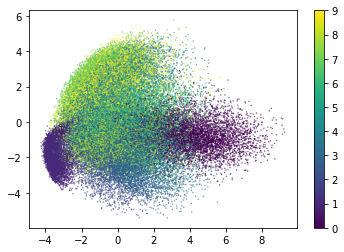

In [37]:
plt.scatter(Xt[:,0],Xt[:,1],c=y_train,s=0.1)
plt.colorbar()

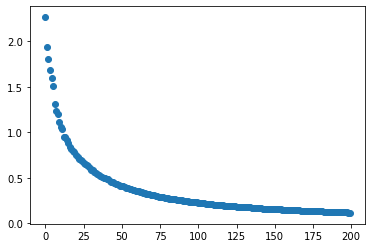

In [38]:
plt.scatter(np.arange(len(Xt[0])),[np.std(Xt[:,i]) for i in range(len(Xt[0]))])

In [39]:
tsne = TSNE(n_components=2,perplexity=30.,n_iter=1000)

In [40]:
Xtsne= tsne.fit_transform(Xt)

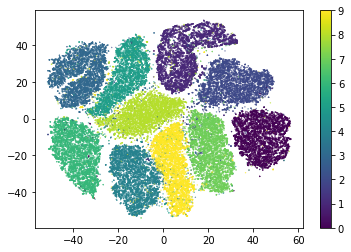

In [41]:
plt.scatter(Xtsne[:,0],Xtsne[:,1],c=y_train,s=0.1)
plt.colorbar()

In [42]:
#DBScan

cluster.DBSCAN(min_samples=40)
cluster.KMeans(n_clusters=8)
cluster.AgglomerativeClustering(n_clusters=2,linkage='ward')
cluster.AgglomerativeClustering(n_clusters=2,linkage='average')
cluster.AgglomerativeClustering(n_clusters=2,linkage='single')
cluster.AgglomerativeClustering(n_clusters=2,linkage='complete')

manifold.MDS(n_components=2,metric=True)
manifold.MDS(n_components=2,metric=False)

# to show kmeans at work
kmeans=cluster.KMeans(n_clusters=3, n_init=1,max_iter=2).fit(X)
kmeans.cluster_centers_
kmeans.labels_

array([1, 0, 1, ..., 1, 2, 0])